In [3]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [4]:
prim_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                 'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## set directory of telescope aperture and list contents

In [5]:
#telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
#print telap_dir
#print("Contents:")
#os.listdir(telap_dir)

In [6]:
#new_telap_dir = os.path.abspath("../InputMasks/TelAp")
new_telap_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v4/TelAp")
if not os.path.exists(new_telap_dir):
    os.mkdir(new_telap_dir)
    print("created {:s} for binned aperture arrays".format(new_telap_dir))
else:
    print("Destination {:s} already exists".format(new_telap_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_v4/TelAp already exists


## Set basic parameters

In [7]:
overwrite = False
prim_key = "hex3"
secobs_key = "X"
centobs = True
D = 2000
N = 250 # quadrant width after binning
symm = 'quart' # set to either 'quart' or 'half'
gap = 1 # minimum segment gap width at N=250 after rounding to binary

## Load an aperture and a secondary obstruction, plot the product

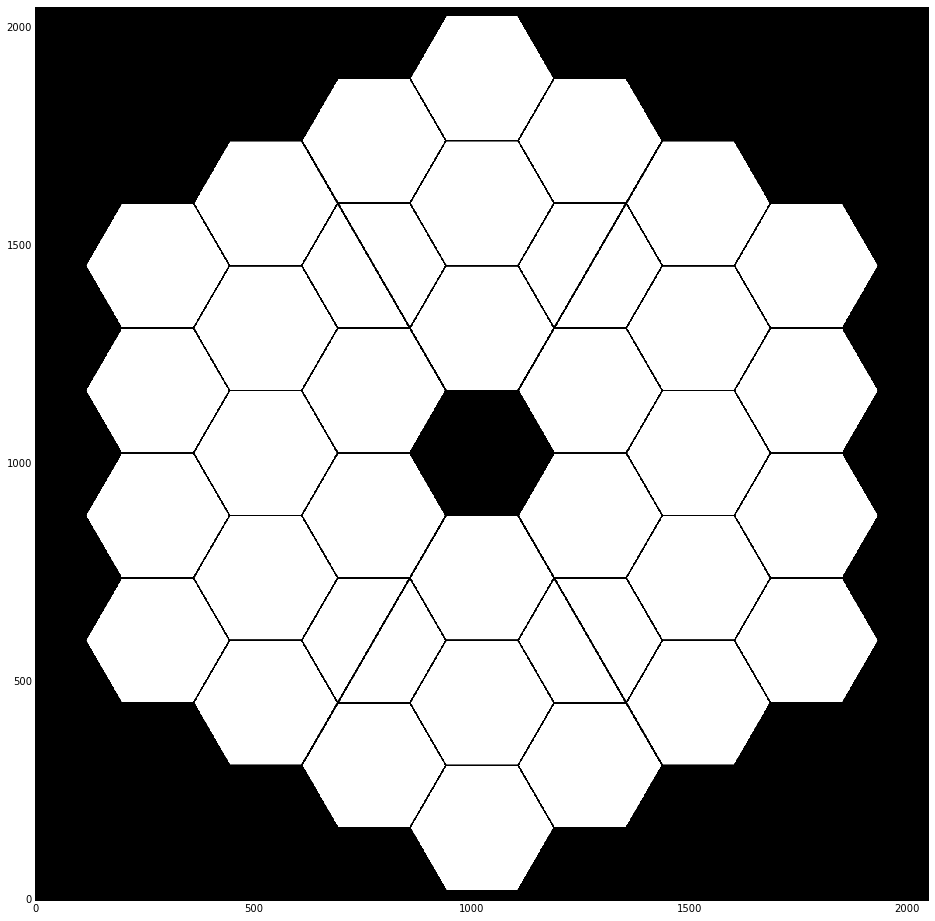

In [8]:
if centobs is True:
    prim_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset.fits".format(prim_key_map[prim_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                            secobs_key_map[secobs_key], D))
else:
    prim_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset_no_central_obsc.fits".format(prim_key_map[prim_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                            secobs_key_map[secobs_key], D))
    
prim_hdulist = fits.open(prim_fname, "readonly")
prim = prim_hdulist[0].data
prim_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()
telap = prim*secobs
plt.figure(figsize=(16,16))
plt.imshow(telap)

### Test the symmetry

In [9]:
L = telap.shape[0]
telap_left = telap[:,:L/2] # left half
telap_right = telap[:,L/2:] # right half
telap_top = telap[L/2:,:] # left half
telap_bot = telap[:L/2,:] # right half
leftright_diff = telap_left - telap_right[:,::-1]
topbot_diff = telap_top - telap_bot[::-1,:]
max_abs_leftright_diff = np.max(np.abs(leftright_diff))
max_abs_topbot_diff = np.max(np.abs(topbot_diff))
print('Max absolute left-right difference = {:g}'.format(max_abs_leftright_diff))
print('Max absolute top-bottom difference = {:g}'.format(max_abs_topbot_diff))

Max absolute left-right difference = 1.62491e-05
Max absolute top-bottom difference = 4.06511e-05


In [10]:
#plt.figure(figsize=(10,6))
#plt.subplot(121)
#plt.imshow(leftright_diff)
#plt.colorbar()
#plt.subplot(122)
#plt.imshow(topbot_diff.T)
#plt.colorbar()

## Pad the obscuration features

In [30]:
if gap is 0:
    max_shift = 0.
if gap is 1:
    max_shift = D*0.2/1000
elif gap is 2:
    max_shift = D*1.1/1000
elif gap is 3:
    max_shift = D*1.8/1000
shift_range = np.linspace(-max_shift,max_shift,7)
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])

print("Shift range on each axis: {}".format(shift_range))
print("Shifting telescope pupil array up to +/-{:.2f} pixels in each direction, using {:d} x,y shift combinations, to build up a padded version".format(max_shift, len(XYshifts_allowed)))

Shift range on each axis: [-0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4       ]
Shifting telescope pupil array up to +/-0.40 pixels in each direction, using 29 x,y shift combinations, to build up a padded version


In [12]:
padded_telap = np.ones(telap.shape)
for (xshift,yshift) in XYshifts_allowed:
    shift = skimage.transform.SimilarityTransform(translation=(xshift,yshift))
    telap_shifted = skimage.transform.warp(telap, shift, order=1)
    #telap_shifted = np.roll(np.roll(telap, yshift, 0), xshift, 1)
    padded_telap *= telap_shifted

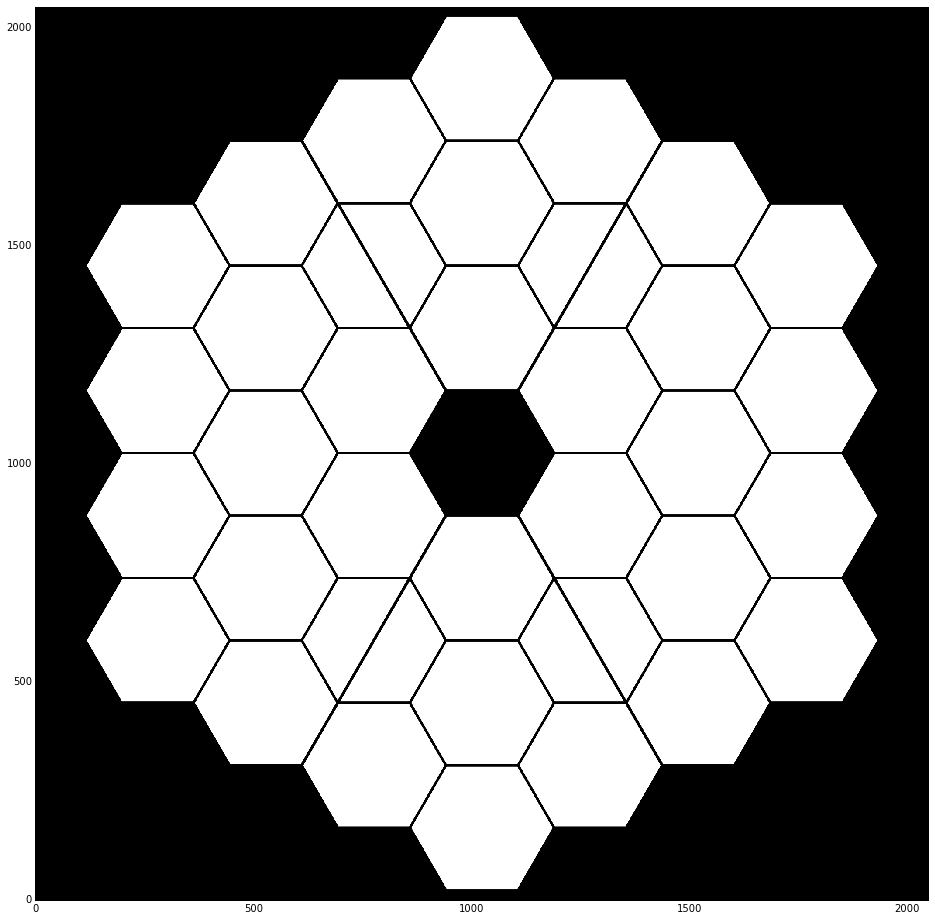

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(padded_telap)

## Bin to abritrary integer size, crop

In [14]:
#N_orig = 1000 # not 1024
#scalefac = float(N)/N_orig
#telap_bin = scipy.ndimage.zoom(telap_obs, scalefac, order=1)
#telap_bin = skimage.transform.rescale(telap_obs, scalefac, order=1)
#L_bin = telap_bin.shape[0]

In [15]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original aperture array {0:d}x".format(scalefac))
telap_bin = np.reshape(padded_telap,(telap.shape[0]/scalefac, scalefac, 
                                     telap.shape[1]/scalefac, scalefac)).mean(1).mean(2)
L_bin = telap_bin.shape[0]

Binning the original aperture array 4x


In [16]:
telap_bin.shape

(512, 512)

In [17]:
if symm is 'half':
    telap_bin_crop = telap_bin[L_bin/2-N:L_bin/2+N, L_bin/2:L_bin/2+N]
    print telap_bin_crop.shape
else:
    telap_bin_crop = telap_bin[L_bin/2:L_bin/2+N, L_bin/2:L_bin/2+N]
    print telap_bin_crop.shape
    # Check max value of outer row and outer column
    #print np.max(telap_binquad[-1,:])
    #print np.max(telap_binquad[:,-1])
    
telap_bin_full = telap_bin[L_bin/2-N:L_bin/2+N, L_bin/2-N:L_bin/2+N]

(250, 250)


(-0.5, 249.5, -0.5, 249.5)

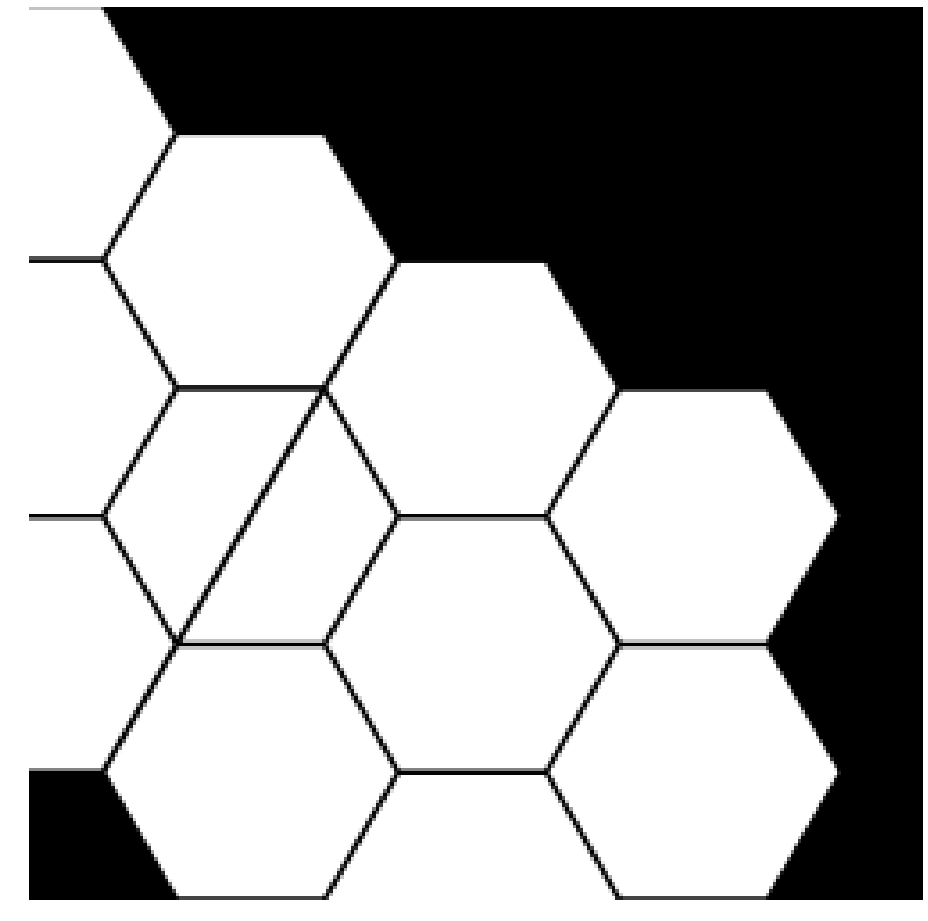

In [18]:
if symm is 'half':
    plt.figure(figsize=(16,32))
    plt.imshow(telap_bin_crop)
else:
    plt.figure(figsize=(16,16))
    plt.imshow(telap_bin_crop)
    #plt.imshow(np.floor(telap_bin_crop))
    #plt.imshow(np.round(telap_bin_crop))
plt.axis('off')

### Form new FITS filename and write

In [19]:
if symm is 'half':
    if centobs is True:
        telap_bin_dat_fname_tail = "TelAp_half_{0:s}{1:s}025cobs1gap{2:1d}_N{3:04d}.dat".format(
                                    prim_key, secobs_key, gap, N)
        telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)
    else:
        telap_bin_dat_fname_tail = "TelAp_half_{0:s}{1:s}025cobs0gap{2:1d}_N{3:04d}.dat".format(
                                    prim_key, secobs_key, gap, N)
        telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)
else:
    if centobs is True:
        telap_bin_dat_fname_tail = "TelAp_quart_{0:s}{1:s}025cobs1gap{2:1d}_N{3:04d}.dat".format(
                                    prim_key, secobs_key, gap, N)
        telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)
    else:
        telap_bin_dat_fname_tail = "TelAp_quart_{0:s}{1:s}025cobs1gap{2:1d}_N{3:04d}.dat".format(
                                    prim_key, secobs_key, gap, N)
        telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)

#telap_binquad_fits_fname_tail = "TelAp_quart_{0:s}_{1:s}025sm1_N{2:04d}.fits".format(telap_key, secobs_key, N)
#telap_binquad_fits_fname = os.path.join(binned_telap_dir, telap_binquad_fits_fname_tail)

In [20]:
#telap_binquad_hdu = fits.PrimaryHDU(telap_binquad)
#telap_binquad_hdu.writeto(telap_binquad_fits_fname, clobber=True)

In [21]:
if not os.path.exists(telap_bin_dat_fname) or overwrite is True:
    np.savetxt(telap_bin_dat_fname, telap_bin_crop, fmt='%.6f', delimiter=" ")
    print("Wrote binned, cropped telescope aperture array to {0:s}".format(telap_bin_dat_fname))
else:
    print("Telescope aperture array {0:s} already exists, will not overwrite".format(telap_bin_dat_fname))

Telescope aperture array /astro/opticslab1/SCDA/Apertures/InputMasks_v4/TelAp/TelAp_quart_hex3X025cobs1gap1_N0250.dat already exists, will not overwrite


In [22]:
#if os.path.exists(telap_bin_dat_fname): os.remove(telap_bin_dat_fname)

In [23]:
os.listdir(new_telap_dir)

['TelAp_quart_hex4X025cobs1gap3_N0125.dat',
 'TelAp_full_hex4X025cobs1gap3_N0125.fits',
 'TelAp_quart_hex3X025cobs1gap1_N0125.dat',
 'TelAp_full_hex3X025cobs1gap1_N0125.fits',
 'TelAp_quart_hex3X025cobs1gap0_N0125.dat',
 'TelAp_full_hex3X025cobs1gap0_N0125.fits',
 'TelAp_quart_hex3X025cobs1gap3_N0250.dat',
 'TelAp_quart_hex3X025cobs1gap0_N0250.dat',
 'TelAp_quart_hex3X025cobs1gap1_N0250.dat',
 '.nfs.2005102b.63b0',
 'TelAp_full_hex3X025cobs1gap0_N0250.fits',
 'TelAp_full_hex3X025cobs1gap1_N0250.fits',
 'TelAp_quart_hex3X025cobs1gap2_N0250.dat',
 'TelAp_full_hex3X025cobs1gap2_N0250.fits',
 'TelAp_full_hex3X025cobs1gap3_N0250.fits',
 'TelAp_quart_hex3X025cobs1gap3_N0125.dat',
 'TelAp_full_hex3X025cobs1gap3_N0125.fits',
 'TelAp_quart_hex3X025cobs1gap2_N0125.dat',
 'TelAp_full_hex3X025cobs1gap2_N0125.fits']

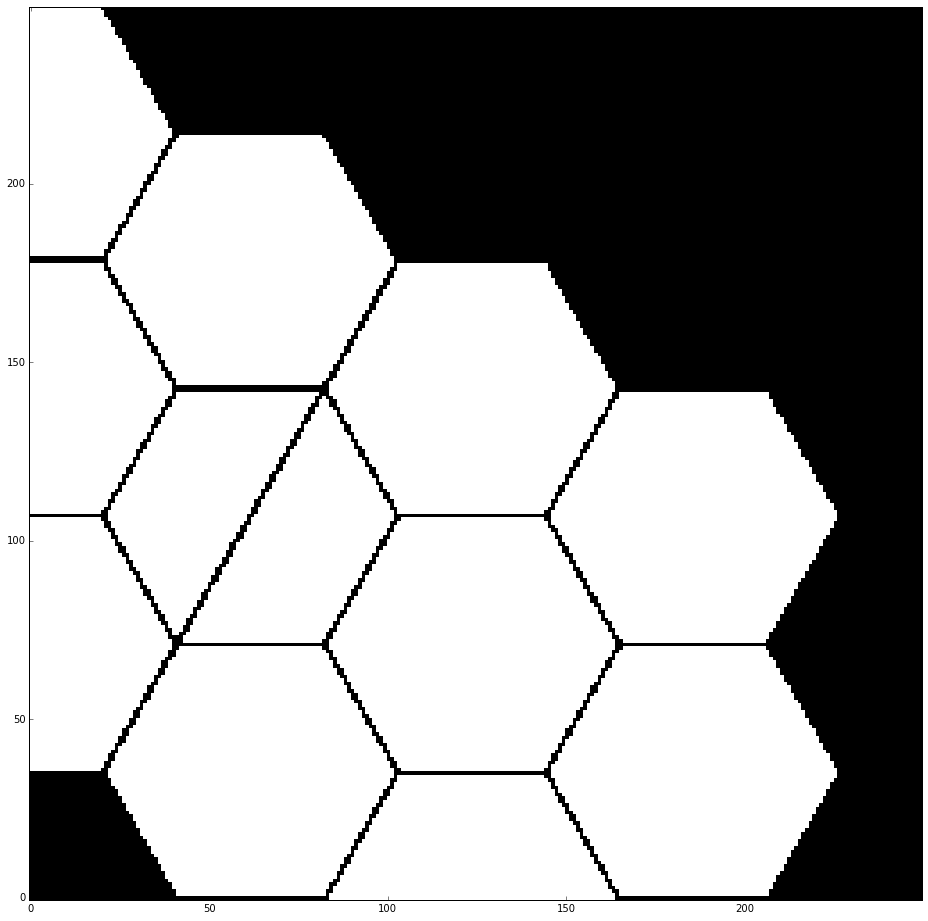

In [24]:
telap_load = np.loadtxt(telap_bin_dat_fname)
plt.figure(figsize=(16,16))
plt.imshow(np.round(telap_load))

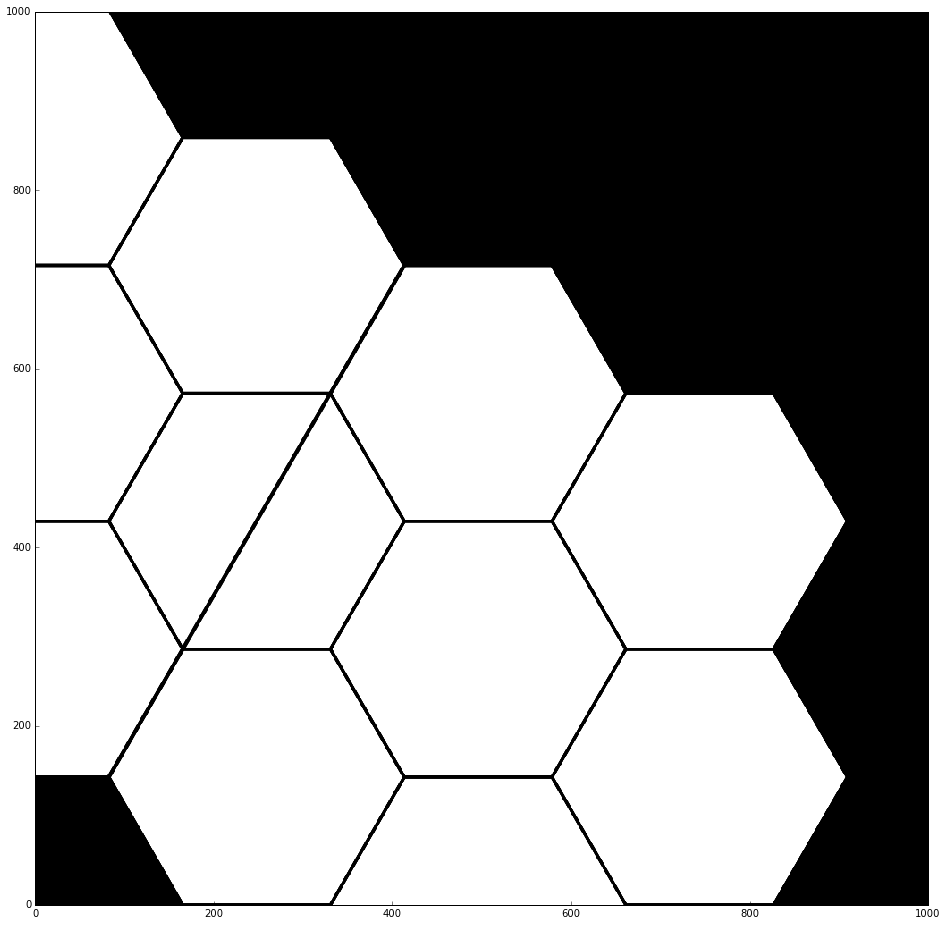

In [26]:
plt.figure(figsize=(16,16))

plt.imshow(telap[1024:2024,1024:2024])

## Write full, rounded telescope pupil to FITS

In [27]:
fits_fname = telap_bin_dat_fname_tail.replace("quart", "full")
fits_fname = fits_fname.replace("half", "full")
fits_fname = fits_fname.replace(".dat", ".fits")
fits_fname = os.path.join(new_telap_dir, fits_fname)

if not os.path.exists(fits_fname) or overwrite==True:
    telap_full_hdu = fits.PrimaryHDU(np.round(telap_bin_full).astype(int))
    telap_full_hdu.writeto(fits_fname, clobber=True)
    print("Wrote full, rounded telescope pupil to {:s}".format(fits_fname))

In [28]:
#os.remove(fits_fname)